Diabetes data is a representative one for classifier model designs as well as fitting for prediction.

In [33]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from math import log
import xgboost as xgb

# does a person have diabetes or not? target: Outcome

path = 'test_diabetes.csv'
    

def parse(path):
    '''
    given: path to file
    return: filtered df
    '''
    df = pd.read_csv(path,delimiter=';')
    
    # replace what is indicative
    df.loc[df['Insulin'] == 'Zero', 'Insulin'] = 0
    df['Insulin'] = df['Insulin'].astype(float)
    df['Age'] = df[df['Age'] > 0]
    
    cols = df.columns
    filter_df = df
    for col in cols:
        filter_df = filter_df[filter_df[col].notnull()]

    # with some assumption.. Yes = 1 No = 0
    filter_df.loc[filter_df['Outcome'] == 'Y', 'Outcome'] = 1
    filter_df.loc[filter_df['Outcome'] == 'N', 'Outcome'] = 0
    filter_df['Outcome'] = filter_df['Outcome'].astype(bool)

    return filter_df

def lognorm(df):
    
    cols = df.columns
    for col in cols:
        if col == 'Outcome':
            continue
        if (df[col] <=0).any():
            continue
        df[col] = df[col].apply(lambda x: log(x))
    return df

Logistic regression was not performant enough, even after regularizing to make the preprocessing effective. Or with ovesampling or augmenting of the data, to balance the shortage of negative samples.

Deploying Extreme Gradient Boost Classifier with oversampling however, drastically improved the measure of interest. Other than the commonly observed recall and accuracy, my attention was on getting the false negative rate low enough. 

This is due to the data being of medical nature, where the modeller should ensure that the model they design do not fail to detect the patients who should take adequate measures to address their conditions.

In [55]:
# feature engineering
import graphviz
from collections import Counter

def preprocess(df):
    '''
    given: data
    return: data whose predictors are min-max scaled
    '''
    cols = df.columns
    for col in cols:
        if col == 'Outcome':
            continue
        min_ = df[col].values.min()
        xsc = df[col].values.max() - min_
        df[col] = df[col].apply(lambda x: (x - min_)/xsc)
    return df

def fit(X_train, y_train, X_test, y_test):
    ''' 
    given: training data
    return: fit model
    '''
#     logreg = LogisticRegression(
#                                 penalty='l1',
#                                 solver='liblinear', 
#                                 C=10.0, 
#                                 random_state=0
#                                 )
    model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42, 
                              eval_metric="auc")

    model.fit(X_train, y_train, 
              early_stopping_rounds=10, 
              eval_set=[(X_test, y_test)], 
              verbose=False)
    # plots the importance of each feature(predictor) by Fscore
    xgb.plot_importance(model)

    # setting size makes it visible, but very slow to load
    fig, ax = plt.subplots(figsize=(480,120))
    
    # plots decision trees using matplotlib
    xgb.plot_tree(model, 
                  num_trees=model.best_iteration, 
                  rankdir='LR',
                  ax =ax)
    plt.show()
    
    # using graphviz instance - does not show here
   # xgb.to_graphviz(model, 
   #                 num_trees=model.best_iteration)
    
    return model

def get_prediction(model, X_test):
    '''
    given: model and test data
    return: predictions on test data
    '''
    y_pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)
    return y_pred, pred_prob


def get_validation(predictions, true):
    '''
    given: predictions and true values
    return: confusion matrix
    '''
    cnf_matrix = metrics.confusion_matrix(true, predictions)
    
    class_labels =[False, True] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)
    
    # heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g')
    
    ax.xaxis.set_label_position("top")
    
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    return cnf_matrix

def oversample(X, y):
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return X_resampled, y_resampled

def augment(X, y):
    findex = y.index[y==False].tolist()
    moref = X.loc[findex, :]
    X = pd.concat([X, moref])
    moref = y.loc[findex]
    y = pd.concat([y, moref])
    return X, y

def execute(X, y):
 
    X, y = oversample(X, y) # better
    X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 0)
    
    a, b = y_train[y_train==True].count(), y_train[y_train==False].count()
    print('train positive ', a)
    print('train negative ', b)
    print('percentage ', a/(a+b))

    tp = y_test[y_test==True].count()
    tn = y_test[y_test==False].count()
    print('test positive ', tp)
    print('test negative ', tn)

    model = fit(X_train, y_train, X_test, y_test)
    y_pred, pred_prob = get_prediction(model, X_test)

    pp = np.sum(y_pred)
    pf = np.sum(~y_pred)
    print('positive outcome ', pp)
    print('negative outcome ', pf)

    cnf_matrix = get_validation(y_pred, y_test)
    evaluate(cnf_matrix)
    
def evaluate(cnf_matrix):
    '''
    given: confusion matrix [List[List[int]]]
    return: None
    '''    
    TP, FN, TN, FP = cnf_matrix[1][1], cnf_matrix[1][0], cnf_matrix[0][0], cnf_matrix[0][1]
    print('Evaluation')
    print('Accuracy: ', (TP+TN)/(TP+FN+TN+FP))
    print('Precision: ', TP/(TP+FP))
    print('Recall/True positive rate: ', TP/(TP+FN))
    print('False positive rate: ',FP/(FP+TN))
    print('False negative rate: ',FN/(FN+TN))
    
def crossval(X, y):
    predictions = cross_val_predict(model, X, y, cv = 5)

    return predictions

Logistic regression is a scale-invariant model, and one that works moderately well in a balanced data. In this case however, the aid of XGBClassifier that parallelizes the learning of decision trees improved the model performance drastically. It handles the grid search for parameter tuning internally yet not forsaking the speed of training. This may be explained by its leverage of openMP library.

train positive  291
train negative  298
percentage  0.4940577249575552
test positive  102
test negative  95


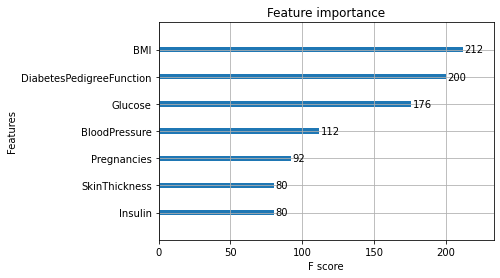

positive outcome  85
negative outcome  112
Evaluation
Accuracy:  0.8934010152284264
Precision:  0.9764705882352941
Recall/True positive rate:  0.8137254901960784
False positive rate:  0.021052631578947368
False negative rate:  0.16964285714285715


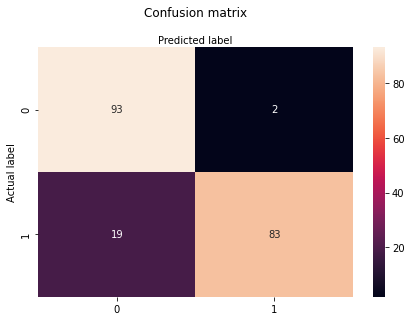

In [56]:
df = parse(path)
df = lognorm(df)
df = preprocess(df)

cols = list(df.columns)
cols.pop()
X = df[cols]
y = df['Outcome']

execute(X, y)